## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

## EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path_images = "../../../datasets/faces/"

data_gen = ImageDataGenerator(rescale = 1./255.)

data_gen_flow = data_gen.flow_from_directory(
    path_images,
    target_size = (150,150),
    batch_size = 16,
    class_mode = 'sparse',
    seed = 12345
)


images, _ = next(data_gen_flow)

df_ages = pd.read_csv("../../../datasets/faces/labels.csv")

print(df_ages.head())

print(images.shape)

print(df_ages.shape)

Found 7591 images belonging to 1 classes.
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
(16, 150, 150, 3)
(7591, 2)


Se cargaron 16 imágenes con dimensiones de 150 píxeles de alto por 150 píxeles de ancho, cada una con tres canales de color (RGB). Por otro lado, el conjunto de datos en formato csv contiene 7,951 registros, con dos características o columnas.

### Distribución de la edad

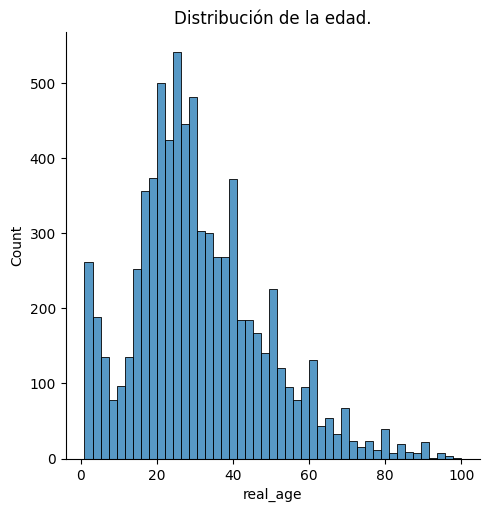

In [3]:
sns.displot(df_ages['real_age'])
plt.title('Distribución de la edad.')
plt.show()

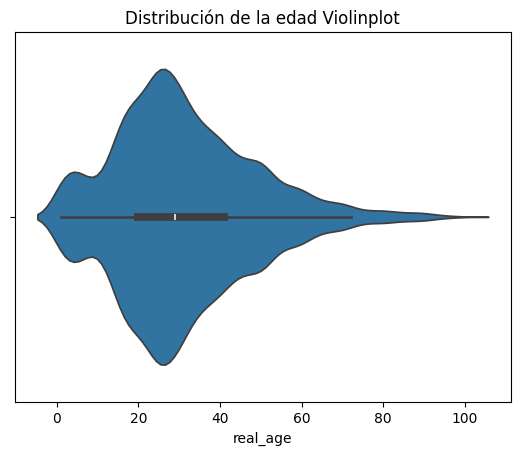

In [4]:
sns.violinplot(x='real_age', data=df_ages)
plt.title("Distribución de la edad Violinplot")
plt.show()

In [5]:
df_ages['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Podemos observar que la edad mínima y máxima de las personas en este conjunto de datos es 1 y 100, respectivamente. La distribución está sesgada hacia la derecha, lo que indica que hay una mayor concentración de personas entre los 10 y 30 años, con una menor cantidad de personas de edades más avanzadas (mayores de 60 años). También se registran algunas personas de edad avanzada, incluso mayores de 80 años.

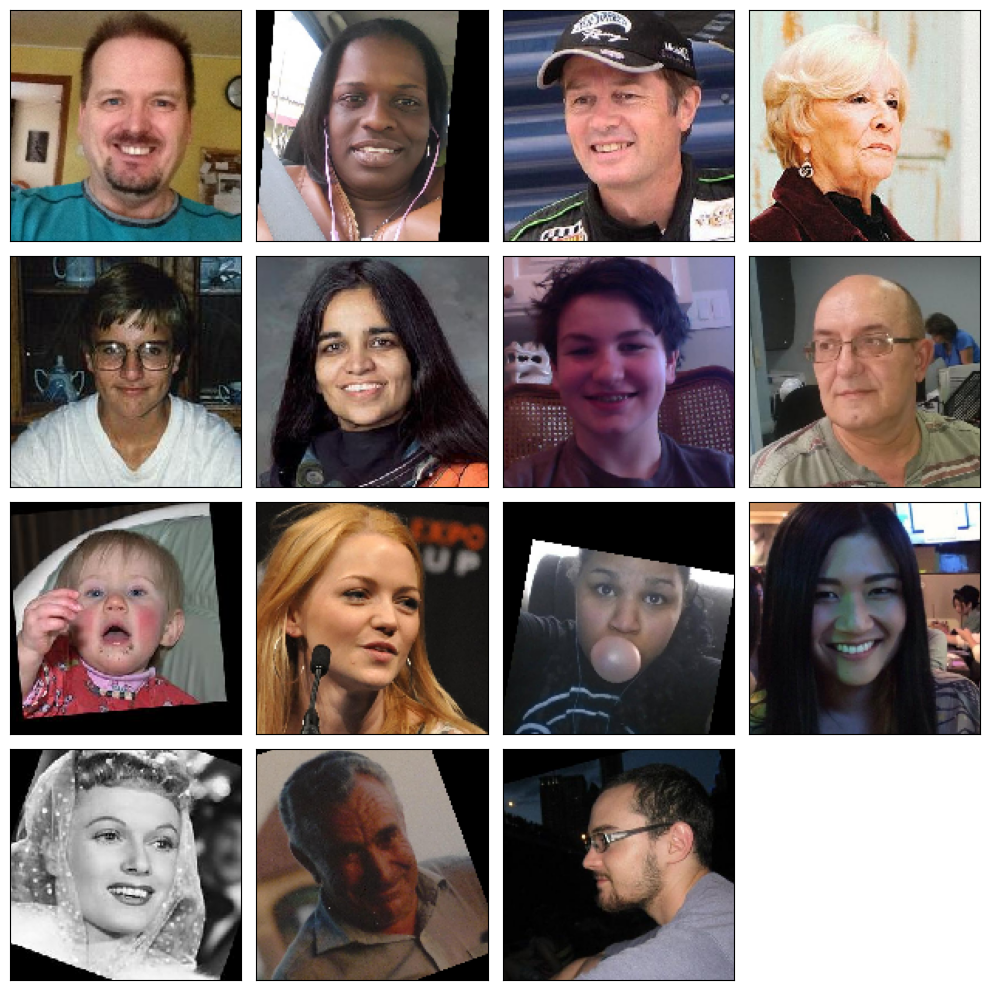

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusiones

Se cargaron 16 imágenes con dimensiones de 150x150 píxeles, cada una con tres canales de color (RGB), lo que indica que estamos trabajando con imágenes a colorl.

Por otro lado, el conjunto de datos en formato csv tiene 7,951 registros y dos características. Al analizar la distribución de la edad, observamos que la edad mínima es 1 año y la máxima es 100 años. La distribución está sesgada a la derecha, lo que significa que hay mayor cantidad de personas entre los 10 y 30 años. A medida que la edad aumenta, los registros disminuyen, sobre todo a partir de los 60 años, aunque también se registran algunas personas de edad avanzada, incluso mayores de 80 años.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    # coloca tu código aquí
    
    train_gen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1./255.
    )
    
    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe = df_ages,
        directory = path,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150,150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'training',
        seed = 42
    )

    return train_gen_flow


In [9]:
features_train, target_train = next(load_train(path_images+"final_files/"))

Found 5694 validated image filenames.


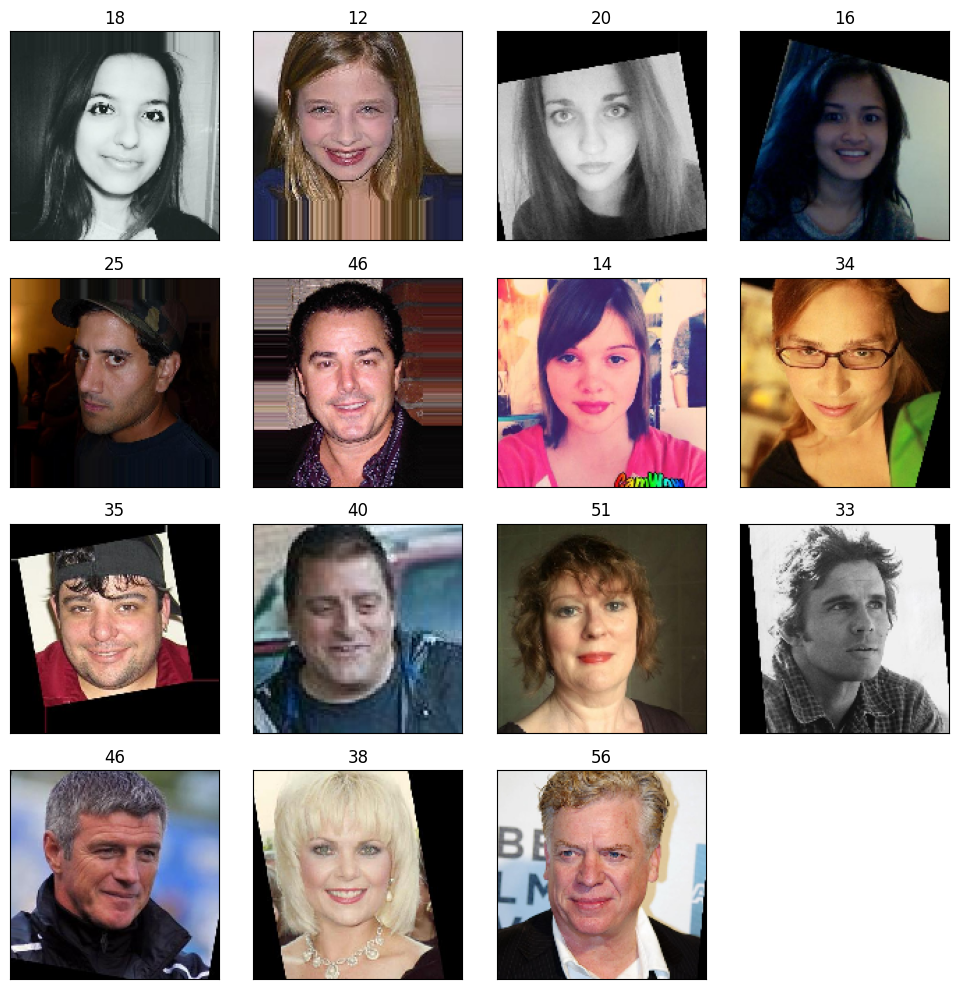

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])
    plt.title(target_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [11]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    #  coloca tu código aquí
    
    test_gen = ImageDataGenerator(
        validation_split = 0.25,
        rescale = 1./255.
    )
    
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe = df_ages,
        directory = path,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (150,150),
        batch_size = 16,
        class_mode = 'raw',
        subset = 'validation',
        seed = 42
    )

    return test_gen_flow

Found 1897 validated image filenames.


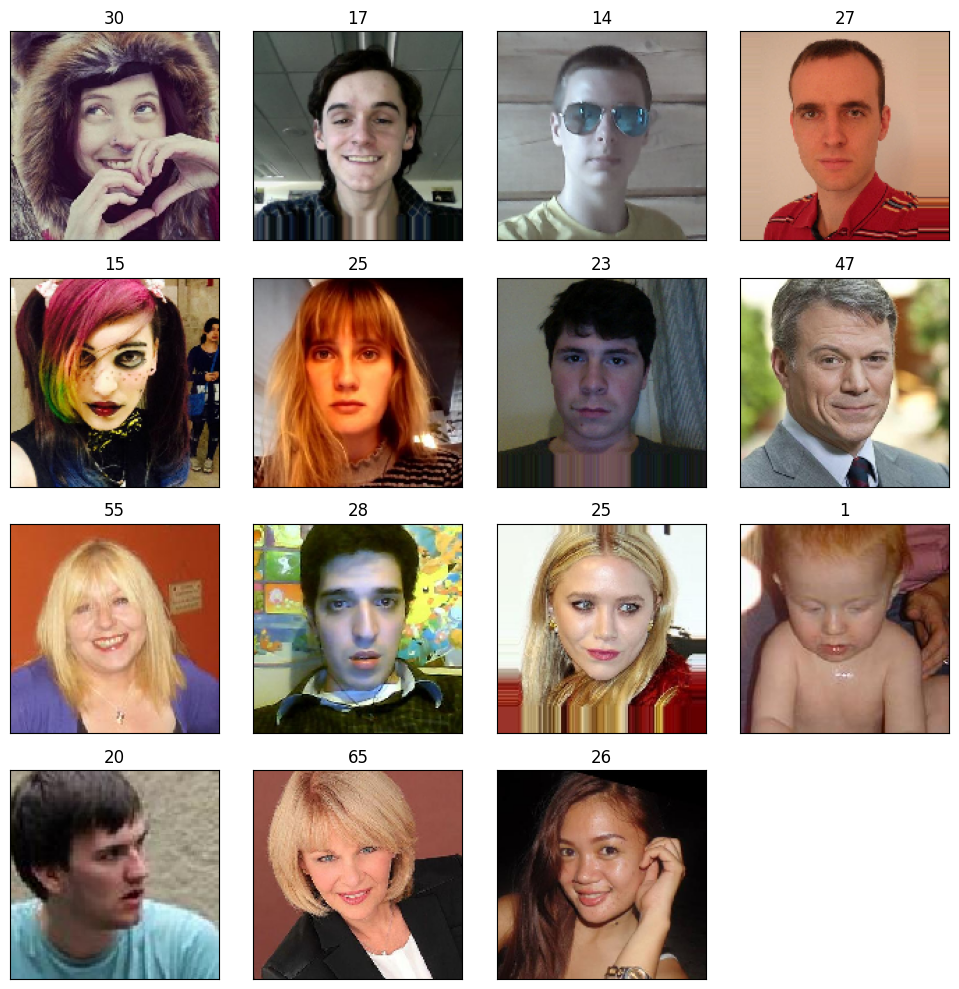

In [12]:
features_test, target_test = next(load_test(path_images+"final_files/"))

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_test[i])
    plt.title(target_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [13]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    #  coloca tu código aquí
    
    backbone = ResNet50(
        input_shape = input_shape,
        weights = 'imagenet',
        include_top = False
    )
    
    # Creación del modelo.
    
    model = Sequential()
    
    # Capa ResNet.
    
    model.add(backbone)
    
    # Capa Average Pooling
    
    model.add(GlobalAveragePooling2D())
    
    # Capa Dense con 1 nodo y función de activación relu.
    model.add(Dense(units = 1, activation = 'relu'))

    
    # Optmizador 
    optimizer = Adam(learning_rate = 0.0001)
    
    # Método compile
    model.compile(
        loss = 'mse',
        optimizer = optimizer,
        metrics = ['mae']
    )
    
    return model

In [14]:
def train_model(model, train_data, test_data, batch_size = None, epochs = 20,
                steps_per_epoch = None, validation_steps = None):

    """
    Entrena el modelo dados los parámetros
    """
    
    #  coloca tu código aquí
    
    model.fit(
        train_data,
        batch_size = batch_size,
        epochs = epochs,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        verbose = 2,
        validation_data = test_data
    )
    

    return model

In [16]:
train_data = load_train(path_images+"final_files/")
test_data = load_test(path_images+"final_files/")

model = create_model(input_shape=(150,150,3))

train_model(model,train_data=train_data, test_data=test_data, epochs = 3)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/3
356/356 - 462s - loss: 225.3234 - mae: 10.8857 - val_loss: 734.9429 - val_mae: 22.0924 - 462s/epoch - 1s/step
Epoch 2/3
356/356 - 379s - loss: 80.4711 - mae: 6.8595 - val_loss: 173.2979 - val_mae: 9.5939 - 379s/epoch - 1s/step
Epoch 3/3
356/356 - 412s - loss: 47.4532 - mae: 5.2924 - val_loss: 84.9897 - val_mae: 6.8801 - 412s/epoch - 1s/step


### Resultado

e implementaron 4 funciones para dividir los conjuntos de datos, entrenar el modelo y obtener los resultados. La red neuronal se construyó utilizando una capa ResNet, una capa de Average Pooling 2D, y una capa densa con una neurona y función de activación ReLU. Al compilar el modelo, se utilizó la función de pérdida mean squared error (MSE), la métrica mean absolute error (MAE) y el optimizador Adam con una tasa de aprendizaje de 0.0001. Las imágenes de entrada y salida tienen dimensiones de 150x150 píxeles, y el modelo fue entrenado durante 3 épocas.

El entrenamiento duró aproximadamente 21 minutos. En la primera época, el conjunto de validación arrojó un MSE de 734.94 y un MAE de 22.0924 años, lo cual refleja un valor elevado al inicio. No obstante, en la segunda época, las métricas mejoraron considerablemente, alcanzando un MSE de 173.29 y un MAE de 9.53 años. Nuestro objetivo era llegar a un MAE inferior a 8. Finalmente, en la tercera y última época, se logró un MSE de 98 y un MAE de 6.88 años. Estos resultados muestran que, a medida que el modelo se entrena durante más épocas, las métricas mejoran, alcanzando y superando el objetivo inicial de un MAE inferior a 8.

## Conclusiones

En conclusión, el modelo desarrollado ha mostrado una mejora significativa a lo largo del proceso de entrenamiento. Comenzando con un error medio cuadrático (MSE) y un error absoluto medio (MAE) elevados en la primera época, las métricas mejoraron considerablemente en las siguientes épocas. Al final del entrenamiento, logramos un MAE de 6.88 años, superando el objetivo inicial de un MAE inferior a 8 años. Esto indica que el modelo es capaz de generalizar bien y de ajustar adecuadamente los datos a medida que se entrenan más épocas. El tiempo total de entrenamiento fue razonable, teniendo en cuenta el tamaño del conjunto de datos y las características de las imágenes procesadas. En futuras iteraciones, aumentar el número de épocas o ajustar aún más los hiperparámetros podría ayudar a mejorar la precisión del modelo, pero los resultados actuales ya muestran un rendimiento satisfactorio.

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo